In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams['savefig.dpi'] = 300
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath, amsfonts}"]

In [3]:
import torch
from torch import nn
import sbi
from sbi import utils as utils
from sbi.inference import likelihood_estimator_based_potential

/data80/mattho/anaconda3/envs/pt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tools.catalog import Catalog
from tools.plot_tools import binned_plot
get_cen = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

# Load catalog

In [6]:
cat = Catalog().load('data/raw/UchuuUM_sn40_z=0.49-0.494_sm9.5-extralarge_221020_contam.p')

# only rotation 0
rot = 0
cat = cat[(cat.prop['rotation']==rot).values]

Loading catalog from: data/raw/UchuuUM_sn40_z=0.49-0.494_sm9.5-extralarge_221020_contam.p


In [8]:
# load additional properties
props = pd.read_csv('data/raw/halodir_040_m200c1e13_props.csv').drop('Unnamed: 0', axis=1)
props = props.set_index('id')

props = props.reindex(cat.prop['id']).reset_index()

# append additional properties
for c in props.columns:
    if c not in cat.prop.columns:
        cat.prop[c] = props[c]
        
cat.prop['conc'] = cat.prop['Rvir']/cat.prop['rs']
cat.prop['logM'] = np.log10(cat.prop['M200c'])

In [9]:
# cut clusters
mask = cat.prop['M200c'].values >= 1e14
mask = mask & (cat.prop['conc'].values <= 15)
cat = cat[mask]

In [10]:
# cut galaxy sample
vcut = 3785
aperture = 2.3
Ngal_samp = 10

# cylinder cut
for i in range(len(cat)):
    mask = np.abs(cat.gal[i]['vlos']) < vcut
    mask = mask & (cat.gal[i]['Rproj'] < 2.3)
    cat.gal[i] = cat.gal[i][mask]
    cat.prop.loc[i, 'Ngal'] = len(cat.gal[i])
    # TODO: recalculate sigv
cat.par['aperture']=aperture
cat.par['vcut']=vcut

print(len(cat))
cat = cat[cat.prop['Ngal'].values>=10]
print(len(cat))

# now, limit the spectroscopic sampling
for i in range(len(cat)):
    mask = np.random.choice(len(cat.gal[i]), size=Ngal_samp, replace=False)
    cat.gal[i] = cat.gal[i][mask]

71721
71721


# Data exploration

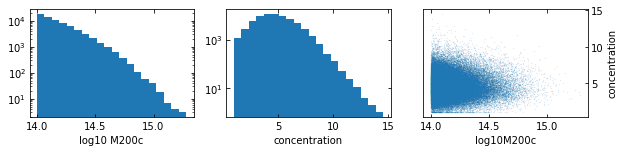

In [11]:
f,axs = plt.subplots(1,3, figsize=(10,2))

axs[0].semilogy()
x = cat.prop['logM']
_ = axs[0].hist(x, bins=20)
axs[0].set_xlabel('log10 M200c')

y = cat.prop['conc']
axs[1].semilogy()
axs[1].hist(y, bins=20)
axs[1].set_xlabel('concentration')


# axs[2].semilogy()
axs[2].plot(x, y, '.', markersize=0.1)
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")
axs[2].set_xlabel('log10M200c')
axs[2].set_ylabel('concentration')

f.savefig('images/m_vs_c.jpg', bbox_inches='tight')

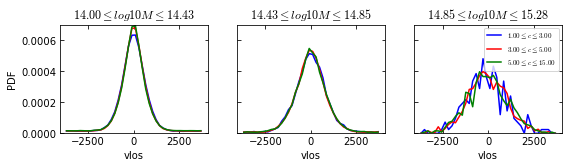

In [12]:
# vlos distribution as a function of mass and concentration

Nm = 3
Nc = 3
Nv = 40

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm+1)
cbins = [1,3,5,15]  # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(-cat.par['vcut'], cat.par['vcut'], Nv+1)

f, axs = plt.subplots(1, Nm, figsize=(3*Nm, 2))
for i in range(Nm):
#     axs[i].semilogy()
    for j in range(Nc):
        mask = (ms>mbins[i]) & (ms<mbins[i+1])
        mask = mask & (cs>cbins[j]) & (cs<cbins[j+1])
        inds = np.argwhere(mask).flatten()
        if len(inds)==0:
            continue
        
        gals = np.concatenate([cat.gal[k]['vlos'] for k in inds]) 
        x, _ = np.histogram(gals, bins=vbins, density=True)
        
        axs[i].plot(get_cen(vbins), x, color=colors[j], 
                    label=f"${cbins[j]:.2f}\leq c\leq {cbins[j+1]:.2f}$")
    
    axs[i].set_title(f"${mbins[i]:.2f}\leq log10M\leq {mbins[i+1]:.2f}$")
    axs[i].set_ylim(0,7e-4)
    axs[i].set_xlabel('vlos')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
plt.legend(fontsize=7)

f.savefig('images/vlos_of_mc.jpg', bbox_inches='tight')

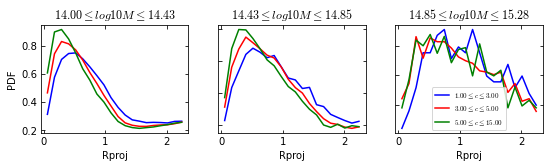

In [13]:
# vlos distribution as a function of mass and concentration

Nm = 3
Nc = 3
Nv = 20

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm+1)
cbins = [1,3,5,15]  # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(0, cat.par['aperture'], Nv+1)

f, axs = plt.subplots(1, Nm, figsize=(3*Nm, 2))
for i in range(Nm):
#     axs[i].semilogy()
    for j in range(Nc):
        mask = (ms>mbins[i]) & (ms<mbins[i+1])
        mask = mask & (cs>cbins[j]) & (cs<cbins[j+1])
        inds = np.argwhere(mask).flatten()
        if len(inds)==0:
            continue
        
        gals = np.concatenate([cat.gal[k]['Rproj'] for k in inds]) 
        x, _ = np.histogram(gals, bins=vbins, density=True)
        
        axs[i].plot(get_cen(vbins), x, color=colors[j], 
                    label=f"${cbins[j]:.2f}\leq c\leq {cbins[j+1]:.2f}$")
    
    axs[i].set_title(f"${mbins[i]:.2f}\leq log10M\leq {mbins[i+1]:.2f}$")
#     axs[i].set_ylim(0,7e-4)
    axs[i].set_xlabel('Rproj')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
plt.legend(fontsize=7)

f.savefig('images/Rproj_of_mc.jpg', bbox_inches='tight')

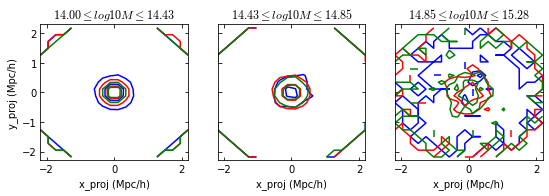

In [14]:
# xproj, yproj as a function of mass and concentration

Nm = 3
Nc = 3
Nv = 20

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm+1)
cbins = [1,3,5,15] # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(-cat.par['aperture'], cat.par['aperture'], Nv+1)
v1, v2 = np.meshgrid(*([get_cen(vbins)]*2))

f, axs = plt.subplots(1,Nm, figsize=(3*Nm, 2.5))
for i in range(Nm):
    for j in range(Nc):
        mask = (ms>mbins[i]) & (ms<mbins[i+1])
        mask = mask & (cs>cbins[j]) & (cs<cbins[j+1])
        inds = np.argwhere(mask).flatten()
        if len(inds)==0:
            continue
        
        galsx = np.concatenate([cat.gal[k]['xproj'] for k in inds]) 
        galsy = np.concatenate([cat.gal[k]['yproj'] for k in inds]) 
        x, _, _ = np.histogram2d(galsx, galsy, bins=[vbins]*2, density=True)
        
        axs[i].contour(v1, v2, x, levels=2, colors=colors[j])
    
    axs[i].set_title(f"${mbins[i]:.2f}\leq log10M\leq {mbins[i+1]:.2f}$")
    axs[i].set_xlabel('x_proj (Mpc/h)')
    axs[i].set_ylim(-cat.par['aperture'], cat.par['aperture'])
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('y_proj (Mpc/h)')
        
f.savefig('images/xyproj_of_mc.jpg', bbox_inches='tight')

# inference

In [15]:
param_names = ['logM','conc']
data_names = ['xproj','yproj','vlos']

num_dim = len(param_names)
prior_lims = torch.Tensor([(cat.prop[x].min(), cat.prop[x].max()) for x in param_names]).T

In [16]:
# separate into train/test
fold = np.random.randint(0, 10, size=len(cat))
i = 0
cat_train = cat[fold==i]
cat_test = cat[fold!=i]

In [17]:
# grab relevant data fields
def construct_dataset(cat):
    gals = np.concatenate(cat.gal, axis=0)
    gals = np.stack([gals[x] for x in data_names], axis=-1)
    theta = np.stack([cat.prop[x].repeat(Ngal_samp).values for x in param_names], 
                     axis=-1)
    return torch.Tensor(gals), torch.Tensor(theta)

gals_tr, theta_tr = construct_dataset(cat_train)
gals_te, theta_te = construct_dataset(cat_test)

In [18]:
# normalize everything to [-1, 1]
gnorm = torch.stack((gals_tr.min(axis=0).values, gals_tr.max(axis=0).values))
tnorm = torch.stack((theta_tr.min(axis=0).values, theta_tr.max(axis=0).values))

def norm(x, norm):
    return 2*(x-norm[0])/(norm[1]-norm[0]) - 1

def unnorm(x, norm):
    return ((x+1)*(norm[1]-norm[0])/2)+norm[0]

gals_trN, theta_trN = norm(gals_tr, gnorm), norm(theta_tr, tnorm)
gals_teN, theta_teN = norm(gals_te, gnorm), norm(theta_te, tnorm)

prior_limsN = norm(prior_lims, tnorm)

In [ ]:
### train maf
from sbi.inference import SNLE

prior = utils.BoxUniform(low=torch.Tensor(prior_limsN[0]), 
                         high=torch.Tensor(prior_limsN[1]), device='cpu')
inference = SNLE(prior, density_estimator='mdn', device='cpu')

density_estimator = inference.append_simulations(theta_trN, gals_trN).train(show_train_summary=True)

# results

## likelihood

In [70]:
# setup mesh
data_lims = np.array([[-cat.par['aperture'], cat.par['aperture']], 
                      [-cat.par['aperture'], cat.par['aperture']],
                      [-cat.par['vcut'],cat.par['vcut']]]).T
data_lims = norm(torch.Tensor(data_lims), gnorm)
mesh = np.array(np.meshgrid(*[np.linspace(*(data_lims[:,i]), 50) for i in range(3)]))
meshlist = mesh.reshape(3,-1)

# instantiate likelihood function
likelihood = density_estimator.eval()

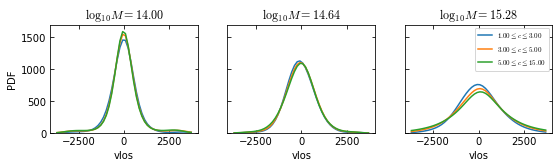

In [71]:
# vlos likelihood as a function of mass and concentration

Nm = 3
Nc = 3
# Nv = 40

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm)
cbins = [1,3,5,15]  # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(-cat.par['vcut'], cat.par['vcut'], 51)

f, axs = plt.subplots(1, Nm, figsize=(3*Nm, 2))
for i in range(Nm):
    for j in range(Nc):
        mi = mbins[i]
        ci = cbins[j]
        thi = norm(torch.Tensor([[mi, ci]]), tnorm)
        
        probs = likelihood.log_prob(torch.Tensor(meshlist).T, 
                                    thi.repeat(meshlist.shape[-1],1))
        probs = probs.reshape(mesh.shape[1:]).detach().cpu().numpy()
        
        axs[i].plot(
            get_cen(vbins),
            np.exp(scipy.special.logsumexp(probs, axis=(0,1))), 
            label=f"${cbins[j]:.2f}\leq c\leq {cbins[j+1]:.2f}$")
    
    axs[i].set_title(f"$\log_{{10}}M = {mbins[i]:.2f}$")
    axs[i].set_ylim(0, 1700)
    axs[i].set_xlabel('vlos')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
plt.legend(fontsize=7)

f.savefig('images/vlos_lik.jpg', bbox_inches='tight')

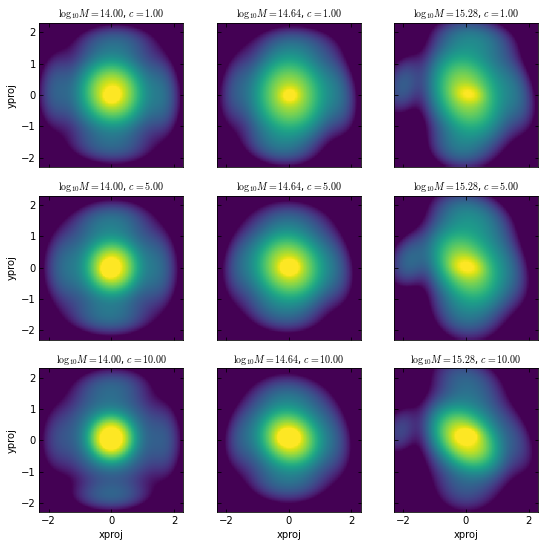

In [72]:
# xproj, yproj likelihood as a function of mass and concentration

Nm = 3
Nc = 3
# Nv = 40

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm)
cbins = [1,5,10,15]  # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(-cat.par['vcut'], cat.par['vcut'], 51)

f, axs = plt.subplots(Nc, Nm, figsize=(3*Nm, 3*Nc))
for i in range(Nm):
    for j in range(Nc):
        mi = mbins[i]
        ci = cbins[j]
        thi = norm(torch.Tensor([[mi, ci]]), tnorm)
        
        probs = likelihood.log_prob(torch.Tensor(meshlist).T, 
                                    thi.repeat(meshlist.shape[-1],1))
        probs = probs.reshape(mesh.shape[1:]).detach().cpu().numpy()
        
        im = axs[j, i].imshow(
            scipy.special.logsumexp(probs, axis=-1), 
            vmin=0, vmax=4,
            extent = gnorm.T[:2].flatten()
        )
    
        axs[j,i].set_title(f"$\log_{{10}}M = {mbins[i]:.2f}$, $c = {cbins[j]:.2f}$", fontsize=10)
#     axs[j,i].set_xlabel('vlos')
        if i!=0:
            axs[j,i].yaxis.set_tick_params(labelleft=False)
        else:
            axs[j,i].set_ylabel('yproj')
            
        if j!=Nc-1:
            axs[j,i].xaxis.set_tick_params(labelbottom=False)
        else:
            axs[j,i].set_xlabel('xproj')
            
f.savefig('images/xyproj_lik.jpg', bbox_inches='tight')

## posterior 

In [73]:
def calc_posterior(density_estimator, testN, Nsamp=30):
    mbins, cbins = [np.linspace(*(prior_limsN[:,i]), Nsamp) for i in range(2)]
    mesh = np.array(np.meshgrid(mbins, cbins))
    meshlist = mesh.reshape(2,-1)
    
    # calc joint posterior
    x_o = testN
    potential_fn, parameter_transform = likelihood_estimator_based_potential(
        density_estimator, prior, x_o
    )
    logprob = potential_fn(torch.Tensor(meshlist.T), track_gradients=False)
    logprob = logprob.reshape(mesh.shape[1:]).detach().cpu().numpy()
    prob = np.exp(logprob)
    prob /= np.sum(prob)
    mbins, cbins = unnorm(np.array([mbins,cbins]).T, np.array(tnorm)).T
    return mbins, cbins, prob

def get_mc_percentiles(density_estimator, testN, ps=[16,50,84]):
    mbins, cbins, prob = calc_posterior(density_estimator, testN, Nsamp=100)
    ps = np.array(ps)/100
    
    # get m percentiles
    cdf = np.cumsum(np.sum(prob, axis=0))
    pm = np.interp(ps, cdf, mbins)
    
    # get c percentiles
    cdf = np.cumsum(np.sum(prob, axis=1))
    pc = np.interp(ps, cdf, cbins)
    
    return pm, pc

In [107]:

potential_fn, parameter_transform = likelihood_estimator_based_potential(
    density_estimator, prior, testN[:5]
)

In [115]:
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform, 
    method='slice_np_vectorized', num_chains=16
)

In [116]:
posterior.map(show_progress_bars=True)

 Optimizing MAP estimate. Iterations: 283 / 1000. Performance in iteration 280: 1.56 (= unnormalized log-prob)

Running vectorized MCMC with 1 chains:   5%|▌         | 530/10100 [00:25<02:15, 70.51it/s]

 Optimizing MAP estimate. Iterations: 1000 / 1000. Performance in iteration 1000: 1.57 (= unnormalized log-prob)

tensor([-0.9997, -0.4337])

In [117]:
samps = posterior.sample((1000,), show_progress_bars=True)


Running vectorized MCMC with 16 chains:  99%|█████████▉| 11520/11600 [00:18<00:00, 619.25it/s]


In [121]:
samps.median(axis=0)

torch.return_types.median(
values=tensor([-0.5212, -0.0487]),
indices=tensor([128, 701]))

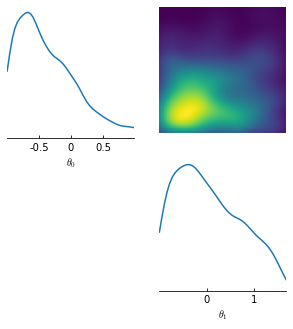

In [118]:
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=samps,
    # limits=torch.tensor([[-2.5, 2.5]] * 3),
    upper=['kde'],
    diag=["kde"],
    figsize=(5, 5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

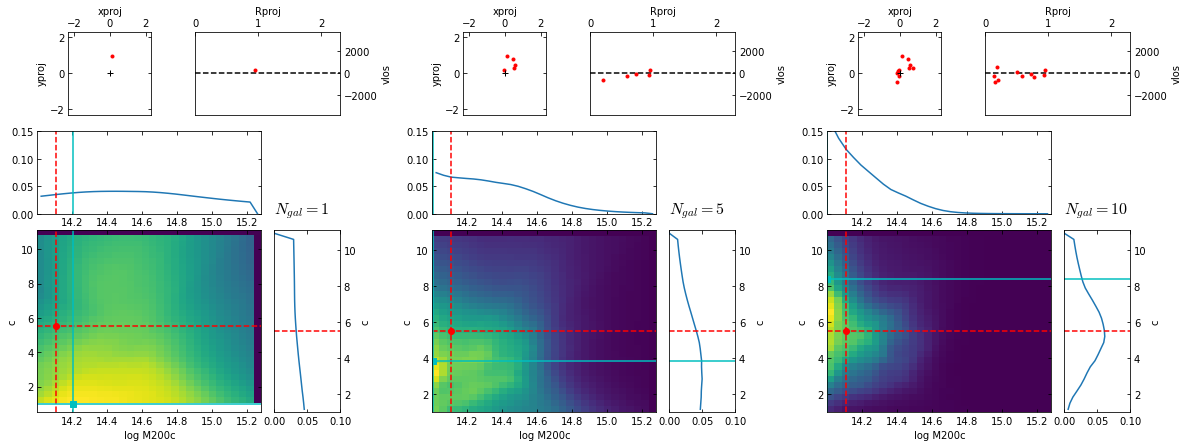

In [87]:
Ngals = [1,5,10]

f = plt.figure(figsize=(7*len(Ngals),7))
gs = mpl.gridspec.GridSpec(4, 5*len(Ngals), wspace=0.2)

ind = np.random.randint(len(gals_teN)/10)
# ind = 7014
# ind = 38299
# ind = 61766
testN = gals_teN[Ngal_samp*ind:Ngal_samp*(ind+1)]
test = unnorm(testN, gnorm)
true = theta_te[Ngal_samp*ind]

Mcens = get_cen(np.linspace(*tnorm.T[0], 31))
ccens = get_cen(np.linspace(*tnorm.T[1], 31))

ngali = 0
for i in range(len(Ngals)):
    # xyproj
    ax = f.add_subplot(gs[0,i*5:i*5+2])
    ax.plot(*test[:Ngals[i], :2].T, 'r.')
    ax.plot(0, 0, 'k+')
    ax.set_aspect('equal')
    ax.set_xlim(*gnorm.T[0])
    ax.set_ylim(*gnorm.T[1])
    ax.set_ylabel('yproj')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel('xproj')
    
    # Rproj vlos
    ax = f.add_subplot(gs[0,i*5+2:i*5+4])
    x_ = test[:Ngals[i], :2].T
    x_ = np.sqrt(x_[0]**2 + x_[1]**2)
    y_ = test[:Ngals[i], 2]
    ax.plot([0,3],[0,0],'k--')
    ax.plot(x_, y_, 'r.')
    ax.set_xlim(0, gnorm.T[0,1])
    ax.set_ylim(*gnorm.T[2])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('vlos')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel('Rproj')

    # calc joint posterior
    x_o = testN[:Ngals[i]]
    _, _, prob, MAP = calc_posterior(density_estimator, x_o)
        
    # plot joint posterior
    ax = f.add_subplot(gs[2:,i*5:i*5+3])
    ax.imshow(
        prob,
        aspect='auto', origin='lower',
        vmin=0,
        extent=tnorm.T.flatten()
    )
    ax.axvline(true[0], color='r', linestyle='--')
    ax.axhline(true[1], color='r', linestyle='--')
    ax.axvline(MAP[0], color='c', linestyle='-')
    ax.axhline(MAP[1], color='c', linestyle='-')
    ax.plot(*true, 'ro', markersize=6)
    ax.plot(*MAP, 'cs', markersize=6)
    ax.set_xlabel('log M200c')
    ax.set_ylabel('c')
    
    # plot M marginal
    ax = f.add_subplot(gs[1,i*5:i*5+3])
    ax.plot(
        Mcens,
        np.sum(prob, axis=0)
    )
    ax.axvline(true[0], color='r', linestyle='--')
    ax.axvline(MAP[0], color='c', linestyle='-')
    ax.set_xlim(*tnorm.T[0])
    ax.set_ylim(0, 0.15)
    
    # plot c marginal
    ax = f.add_subplot(gs[2:,i*5+3])
    ax.plot(
        np.sum(prob, axis=1),
        ccens
    )
    ax.axhline(true[1], color='r', linestyle='--')
    ax.axhline(MAP[1], color='c', linestyle='-')
    ax.set_xlim(0,0.1)
    ax.set_ylim(*tnorm.T[1])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('c')
    
    # print Ngal
    ax = f.add_subplot(gs[1, i*5+3])
    ax.axis('off')
    plt.text(0,0,f'$N_{{gal}}={Ngals[i]}$', fontsize=16)
    
# f.savefig('images/ex_posterior.jpg', bbox_inches='tight')

# Adding a systematic

In [554]:
from copy import deepcopy

cat_trainS = deepcopy(cat_train)
cat_testS = deepcopy(cat_test)

In [555]:
# remove center
Rmin = 0.2  # Mpc/h

for cati in [cat_trainS, cat_testS]:
    for i in range(len(cati)):
        mask = cati.gal[i]['Rproj'] > Rmin
        cati.gal[i] = cati.gal[i][mask]

In [728]:
# grab relevant data fields
def construct_dataset(cat):
    gals = np.concatenate(cat.gal, axis=0)
    gals = np.stack([gals[x] for x in data_names], axis=-1)
    Ngals = [len(x) for x in cat.gal]
    theta = np.stack([cat.prop[x].repeat(Ngals).values 
                      for x in param_names], 
                     axis=-1)
    return torch.Tensor(gals), torch.Tensor(theta)

gals_trS, theta_trS = construct_dataset(cat_trainS)
gals_teS, theta_teS = construct_dataset(cat_testS)

In [557]:
# normalize everything to [-1, 1]

def norm(x, norm):
    return 2*(x-norm[0])/(norm[1]-norm[0]) - 1

def unnorm(x, norm):
    return ((x+1)*(norm[1]-norm[0])/2)+norm[0]

gals_trSN, theta_trSN = norm(gals_trS, gnorm), norm(theta_trS, tnorm)
gals_teSN, theta_teSN = norm(gals_teS, gnorm), norm(theta_teS, tnorm)

# prior_limsN = norm(prior_lims, tnorm)

In [562]:
# train maf
from sbi.inference import SNLE

prior = utils.BoxUniform(low=torch.Tensor(prior_limsN[0]), 
                         high=torch.Tensor(prior_limsN[1]))
inference = SNLE(prior, density_estimator='maf')

density_estimator_S = inference.append_simulations(theta_trSN, gals_trSN).train(show_train_summary=True)

 Neural network successfully converged after 144 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 144
        Best validation performance: -0.4831
        -------------------------
        


In [1586]:
# setup mesh
data_lims = np.array([[-cat.par['aperture'], cat.par['aperture']], 
                      [-cat.par['aperture'], cat.par['aperture']],
                      [-cat.par['vcut'],cat.par['vcut']]]).T
data_lims = norm(torch.Tensor(data_lims), gnorm)
mesh = np.array(np.meshgrid(*[np.linspace(*(data_lims[:,i]), 50) for i in range(3)]))
meshlist = mesh.reshape(3,-1)

# instantiate likelihood function
likelihood_S = density_estimator_S.eval()

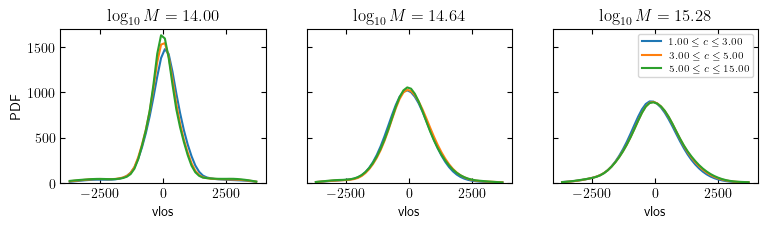

In [1587]:
# vlos likelihood as a function of mass and concentration

Nm = 3
Nc = 3
# Nv = 40

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm)
cbins = [1,3,5,15]  # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(-cat.par['vcut'], cat.par['vcut'], 51)

f, axs = plt.subplots(1, Nm, figsize=(3*Nm, 2))
for i in range(Nm):
    for j in range(Nc):
        mi = mbins[i]
        ci = cbins[j]
        thi = norm(torch.Tensor([[mi, ci]]), tnorm)
        
        probs = likelihood_S.log_prob(torch.Tensor(meshlist).T, 
                                      thi.repeat(meshlist.shape[-1],1))
        probs = probs.reshape(mesh.shape[1:]).detach().numpy()
        
        axs[i].plot(
            get_cen(vbins),
            np.exp(scipy.special.logsumexp(probs, axis=(0,1))), 
            label=f"${cbins[j]:.2f}\leq c\leq {cbins[j+1]:.2f}$")
    
    axs[i].set_title(f"$\log_{{10}}M = {mbins[i]:.2f}$")
    axs[i].set_ylim(0, 1700)
    axs[i].set_xlabel('vlos')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
plt.legend(fontsize=7)

f.savefig('images/vlos_likS.jpg', bbox_inches='tight')

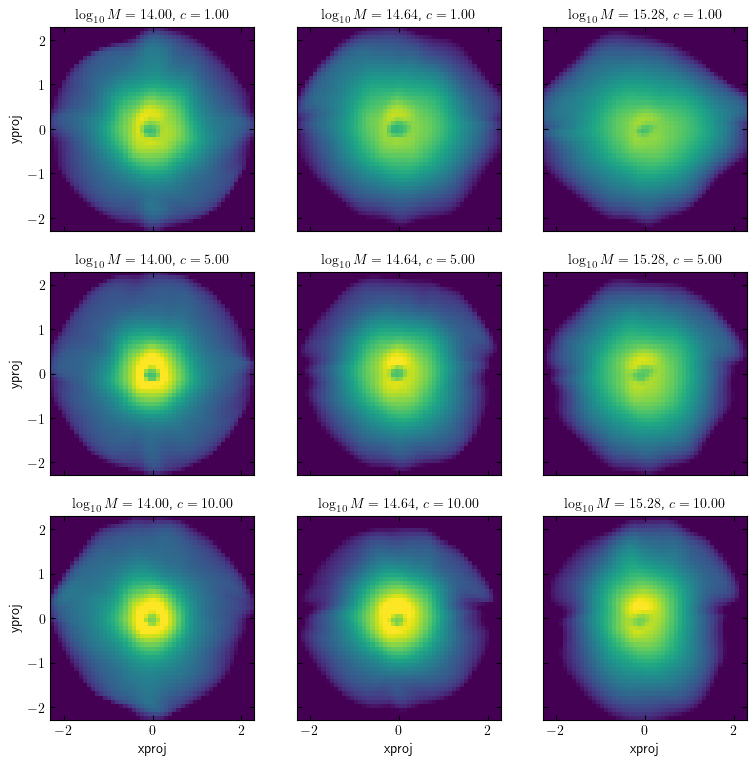

In [1588]:
# xproj, yproj likelihood as a function of mass and concentration

Nm = 3
Nc = 3
# Nv = 40

ms = cat.prop['logM'].values
cs = cat.prop['conc'].values
colors = ['b','r','g','m']

mbins = np.linspace(ms.min(), ms.max(), Nm)
cbins = [1,5,10,15]  # np.linspace(cs.min(), cs.max(), Nc+1)
vbins = np.linspace(-cat.par['vcut'], cat.par['vcut'], 51)

f, axs = plt.subplots(Nc, Nm, figsize=(3*Nm, 3*Nc))
for i in range(Nm):
    for j in range(Nc):
        mi = mbins[i]
        ci = cbins[j]
        thi = norm(torch.Tensor([[mi, ci]]), tnorm)
        
        probs = likelihood_S.log_prob(torch.Tensor(meshlist).T, 
                                    thi.repeat(meshlist.shape[-1],1))
        probs = probs.reshape(mesh.shape[1:]).detach().numpy()
        
        im = axs[j, i].imshow(
            scipy.special.logsumexp(probs, axis=-1), 
            vmin=0, vmax=4,
            extent = gnorm.T[:2].flatten()
        )
    
        axs[j,i].set_title(f"$\log_{{10}}M = {mbins[i]:.2f}$, $c = {cbins[j]:.2f}$", fontsize=10)
#     axs[j,i].set_xlabel('vlos')
        if i!=0:
            axs[j,i].yaxis.set_tick_params(labelleft=False)
        else:
            axs[j,i].set_ylabel('yproj')
            
        if j!=Nc-1:
            axs[j,i].xaxis.set_tick_params(labelbottom=False)
        else:
            axs[j,i].set_xlabel('xproj')
            
f.savefig('images/xyproj_likS.jpg', bbox_inches='tight')

In [1636]:
mesh = np.array(np.meshgrid(*[np.linspace(*(prior_limsN[:,i]),30) for i in range(2)]))
meshlist = mesh.reshape(2,-1)

_, uind = np.unique(theta_teS[:,0]*theta_teS[:,1], return_index=True)
uind = np.sort(uind)

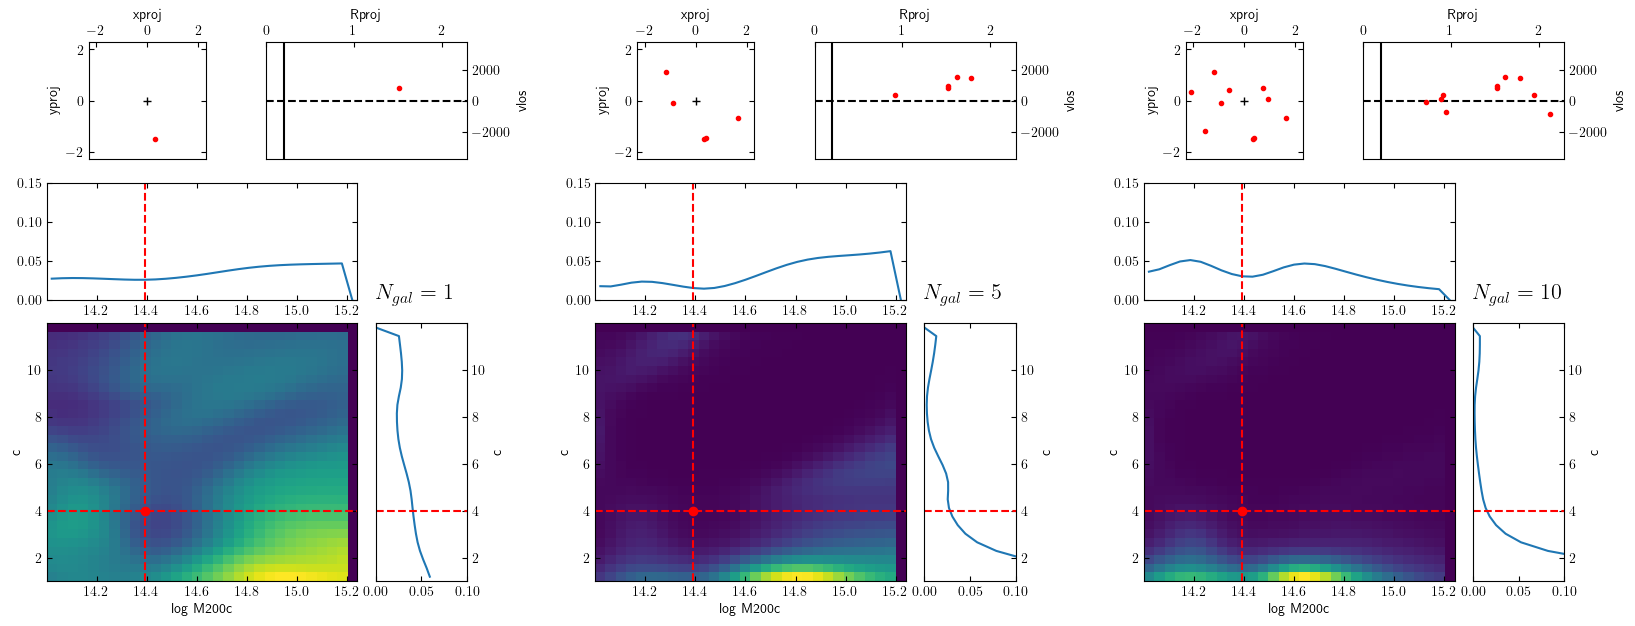

In [1593]:
Ngals = [1,5,-1]

f = plt.figure(figsize=(7*len(Ngals),7))
gs = mpl.gridspec.GridSpec(4, 5*len(Ngals), wspace=0.2)

ind = np.random.randint(len(uind))
# ind = 7014
# ind = 38299
# ind = 61766
testN = gals_teSN[uind[ind]:uind[ind+1]]
test = unnorm(testN, gnorm)
true = theta_teS[uind[ind]]
Ngals[-1] = len(test)

Mcens = get_cen(np.linspace(*tnorm.T[0], 31))
ccens = get_cen(np.linspace(*tnorm.T[1], 31))

ngali = 0
for i in range(len(Ngals)):
    # xyproj
    ax = f.add_subplot(gs[0,i*5:i*5+2])
    ax.plot(*test[:Ngals[i], :2].T, 'r.')
    ax.plot(0, 0, 'k+')
    ax.set_aspect('equal')
    ax.set_xlim(*gnorm.T[0])
    ax.set_ylim(*gnorm.T[1])
    ax.set_ylabel('yproj')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel('xproj')
    
    # Rproj vlos
    ax = f.add_subplot(gs[0,i*5+2:i*5+4])
    x_ = test[:Ngals[i], :2].T
    x_ = np.sqrt(x_[0]**2 + x_[1]**2)
    y_ = test[:Ngals[i], 2]
    ax.axhline(0, color='k', linestyle='--')
    ax.axvline(0.2, color='k', linestyle='-')
    ax.plot(x_, y_, 'r.')
    ax.set_xlim(0, gnorm.T[0,1])
    ax.set_ylim(*gnorm.T[2])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('vlos')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel('Rproj')

    # calc joint posterior
    x_o = testN[:Ngals[i]]
    _, _, prob = calc_posterior(density_estimator, x_o)
        
    # plot joint posterior
    ax = f.add_subplot(gs[2:,i*5:i*5+3])
    ax.imshow(
        prob,
        aspect='auto', origin='lower',
        vmin=0,
        extent=tnorm.T.flatten()
    )
    ax.axvline(true[0], color='r', linestyle='--')
    ax.axhline(true[1], color='r', linestyle='--')
    ax.plot(*true, 'ro', markersize=6)
    ax.set_xlabel('log M200c')
    ax.set_ylabel('c')
    
    # plot M marginal
    ax = f.add_subplot(gs[1,i*5:i*5+3])
    ax.plot(
        Mcens,
        np.sum(prob, axis=0)
    )
    ax.axvline(true[0], color='r', linestyle='--')
    ax.set_xlim(*tnorm.T[0])
    ax.set_ylim(0, 0.15)
    
    # plot c marginal
    ax = f.add_subplot(gs[2:,i*5+3])
    ax.plot(
        np.sum(prob, axis=1),
        ccens
    )
    ax.axhline(true[1], color='r', linestyle='--')
    ax.set_xlim(0,0.1)
    ax.set_ylim(*tnorm.T[1])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('c')
    
    # print Ngal
    ax = f.add_subplot(gs[1, i*5+3])
    ax.axis('off')
    plt.text(0,0,f'$N_{{gal}}={Ngals[i]}$', fontsize=16)
    
# f.savefig('images/ex_posterior.jpg', bbox_inches='tight')

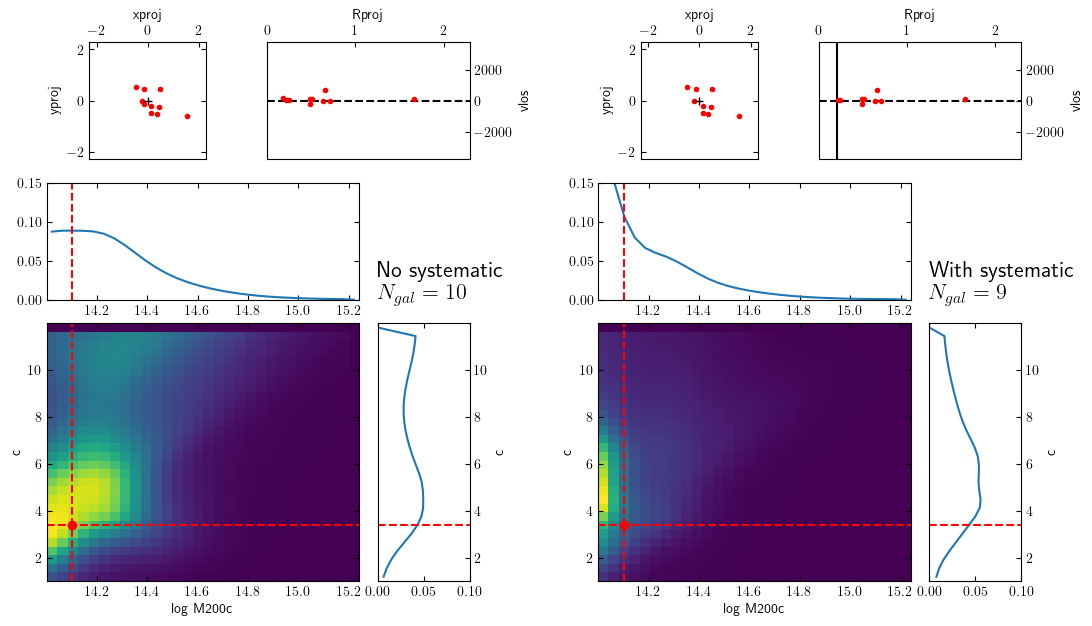

In [1640]:
Ngals = [10,-1]

f = plt.figure(figsize=(7*len(Ngals),7))
gs = mpl.gridspec.GridSpec(4, 5*len(Ngals), wspace=0.2)

ind = np.random.randint(len(uind))
# ind = 7014
# ind = 38299
# ind = 61766
# ind = 15250
# ind = 64618
# ind = 39642

testN = gals_teN[Ngal_samp*ind:Ngal_samp*(ind+1)]
test = unnorm(testN, gnorm)
true = theta_te[Ngal_samp*ind]

indS = np.argwhere(np.all(theta_teS.numpy()==true.numpy(), axis=1))
indS = indS.min(), indS.max()+1

testSN = gals_teSN[indS[0]:indS[1]]
testS = unnorm(testSN, gnorm)
trueS = theta_teS[indS[0]]
Ngals[-1] = len(testS)

Mcens = get_cen(np.linspace(*tnorm.T[0], 31))
ccens = get_cen(np.linspace(*tnorm.T[1], 31))

# ~~~ no systematic ~~~
ngali = 0
i = 0

# xyproj
ax = f.add_subplot(gs[0,i*5:i*5+2])
ax.plot(*test[:Ngals[i], :2].T, 'r.')
ax.plot(0, 0, 'k+')
ax.set_aspect('equal')
ax.set_xlim(*gnorm.T[0])
ax.set_ylim(*gnorm.T[1])
ax.set_ylabel('yproj')
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel('xproj')

# Rproj vlos
ax = f.add_subplot(gs[0,i*5+2:i*5+4])
x_ = test[:Ngals[i], :2].T
x_ = np.sqrt(x_[0]**2 + x_[1]**2)
y_ = test[:Ngals[i], 2]
ax.axhline(0, color='k', linestyle='--')
# ax.axvline(0.2, color='k', linestyle='-')
ax.plot(x_, y_, 'r.')
ax.set_xlim(0, gnorm.T[0,1])
ax.set_ylim(*gnorm.T[2])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel('vlos')
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel('Rproj')

# calc joint posterior
_, _, prob = calc_posterior(density_estimator, testN)

# plot joint posterior
ax = f.add_subplot(gs[2:,i*5:i*5+3])
ax.imshow(
    prob,
    aspect='auto', origin='lower',
    vmin=0,
    extent=tnorm.T.flatten()
)
ax.axvline(true[0], color='r', linestyle='--')
ax.axhline(true[1], color='r', linestyle='--')
ax.plot(*true, 'ro', markersize=6)
ax.set_xlabel('log M200c')
ax.set_ylabel('c')

# plot M marginal
ax = f.add_subplot(gs[1,i*5:i*5+3])
ax.plot(
    Mcens,
    np.sum(prob, axis=0)
)
ax.axvline(true[0], color='r', linestyle='--')
ax.set_xlim(*tnorm.T[0])
ax.set_ylim(0, 0.15)

# plot c marginal
ax = f.add_subplot(gs[2:,i*5+3])
ax.plot(
    np.sum(prob, axis=1),
    ccens
)
ax.axhline(true[1], color='r', linestyle='--')
ax.set_xlim(0,0.1)
ax.set_ylim(*tnorm.T[1])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel('c')

# print Ngal
ax = f.add_subplot(gs[1, i*5+3])
ax.axis('off')
plt.text(0,0,f'No systematic\n$N_{{gal}}={Ngals[i]}$', fontsize=16)


# ~~~ systematic ~~~
ngali = 0
i = 1

# xyproj
ax = f.add_subplot(gs[0,i*5:i*5+2])
ax.plot(*testS[:Ngals[i], :2].T, 'r.')
ax.plot(0, 0, 'k+')
ax.set_aspect('equal')
ax.set_xlim(*gnorm.T[0])
ax.set_ylim(*gnorm.T[1])
ax.set_ylabel('yproj')
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel('xproj')

# Rproj vlos
ax = f.add_subplot(gs[0,i*5+2:i*5+4])
x_ = testS[:Ngals[i], :2].T
x_ = np.sqrt(x_[0]**2 + x_[1]**2)
y_ = testS[:Ngals[i], 2]
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0.2, color='k', linestyle='-')
ax.plot(x_, y_, 'r.')
ax.set_xlim(0, gnorm.T[0,1])
ax.set_ylim(*gnorm.T[2])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel('vlos')
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel('Rproj')

# calc joint posterior
_, _, prob = calc_posterior(density_estimator_S, testSN)

# plot joint posterior
ax = f.add_subplot(gs[2:,i*5:i*5+3])
ax.imshow(
    prob,
    aspect='auto', origin='lower',
    vmin=0,
    extent=tnorm.T.flatten()
)
ax.axvline(trueS[0], color='r', linestyle='--')
ax.axhline(trueS[1], color='r', linestyle='--')
ax.plot(*trueS, 'ro', markersize=6)
ax.set_xlabel('log M200c')
ax.set_ylabel('c')

# plot M marginal
ax = f.add_subplot(gs[1,i*5:i*5+3])
ax.plot(
    Mcens,
    np.sum(prob, axis=0)
)
ax.axvline(trueS[0], color='r', linestyle='--')
ax.set_xlim(*tnorm.T[0])
ax.set_ylim(0, 0.15)

# plot c marginal
ax = f.add_subplot(gs[2:,i*5+3])
ax.plot(
    np.sum(prob, axis=1),
    ccens
)
ax.axhline(trueS[1], color='r', linestyle='--')
ax.set_xlim(0,0.1)
ax.set_ylim(*tnorm.T[1])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel('c')

# print Ngal
ax = f.add_subplot(gs[1, i*5+3])
ax.axis('off')
plt.text(0,0,f'With systematic\n$N_{{gal}}={Ngals[i]}$', fontsize=16)
f.savefig('images/ex_posterior.jpg', bbox_inches='tight')

# Calculate percentiles

## no systematic

### Mass

In [1698]:
# try to uniformly sample from the test set
true = theta_te[::10]
mbins = np.linspace(true[:,0].min(), true[:,0].max(),30)
ncount = 10

mask = np.zeros(len(true), dtype=bool)
for i in range(len(mbins)-1):
    temp = np.argwhere((true[:,0]>mbins[i]) & (true[:,0]<mbins[i+1])).flatten()
    if len(temp)>0:
        indt = np.random.choice(temp, size=min(ncount,len(temp)), replace=False)
        mask[indt]=True
        
# calc percentiles
inds = np.argwhere(mask).flatten()
Ntest = len(inds)

mpercs = np.zeros((Ntest, 3))
cpercs = np.zeros((Ntest, 3))
for i, ind in enumerate(tqdm(inds)):
    testN = gals_teN[10*ind:10*(ind+1)]
    mpercs[i], cpercs[i] = get_mc_percentiles(density_estimator, testN)

true=theta_te[10*inds].numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:28<00:00,  2.89it/s]


IndexError: index 573020 is out of bounds for dimension 0 with size 569550

In [1708]:
print('stderror:', np.std(true[:,0]- mpercs[:,1]))
print('prior std:', np.diff(tnorm[:,0])/np.sqrt(12))

stderror: 0.29738147744940563
prior std: [0.35825416]


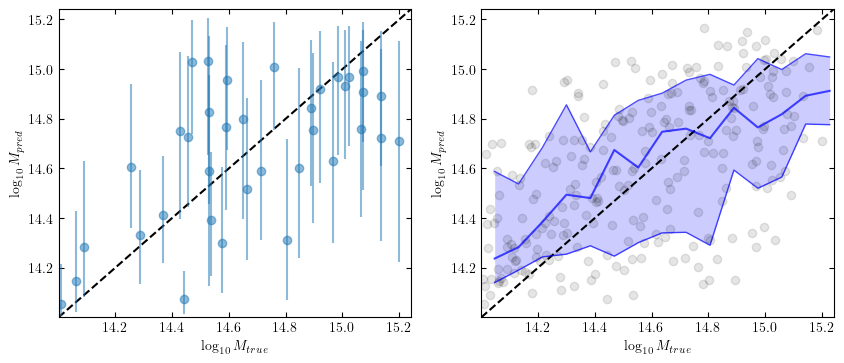

In [1709]:
p = 0.15
mask = np.random.rand(len(true))<p

f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(tnorm.T[0], tnorm.T[0],'k--')
axs[0].errorbar(true[mask,0], mpercs[mask,1], 
                yerr=np.abs(mpercs[mask][:,[0,2]]-mpercs[mask][:,[1]]).T, fmt='o', alpha=0.5)
axs[0].set_xlim(tnorm.T[0])
axs[0].set_ylim(tnorm.T[0])
axs[0].set_xlabel(r'$\log_{10}M_{true}$')
axs[0].set_ylabel(r'$\log_{10}M_{pred}$')

axs[1].plot([14,15.3],[14,15.3],'k--')
axs[1].plot(true[:,0], mpercs[:,1],'ko', alpha=0.1)
binned_plot(true[:,0], mpercs[:,1], 15, color='b', ax=axs[1])
axs[1].set_xlim(tnorm.T[0])
axs[1].set_ylim(tnorm.T[0])
axs[1].set_xlabel(r'$\log_{10}M_{true}$')
axs[1].set_ylabel(r'$\log_{10}M_{pred}$')

f.savefig('mtruepred.jpg', bbox_inches='tight')

### Concentration

In [1710]:
# try to uniformly sample from the test set
true = theta_te[::10]
mbins = np.linspace(true[:,1].min(), true[:,1].max(),30)
ncount = 10

mask = np.zeros(len(true), dtype=bool)
for i in range(len(mbins)-1):
    temp = np.argwhere((true[:,1]>mbins[i]) & (true[:,1]<mbins[i+1])).flatten()
    if len(temp)>0:
        indt = np.random.choice(temp, size=min(ncount,len(temp)), replace=False)
        mask[indt]=True
        
# calc percentiles
inds = np.argwhere(mask).flatten()
Ntest = len(inds)

mpercs = np.zeros((Ntest, 3))
cpercs = np.zeros((Ntest, 3))
for i, ind in enumerate(tqdm(inds)):
    testN = gals_teN[10*ind:10*(ind+1)]
    mpercs[i], cpercs[i] = get_mc_percentiles(density_estimator, testN)

true=theta_te[10*inds].numpy()

  0%|                                                                                                                       | 0/249 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/pt/lib/python3.10/site-packages/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:29<00:00,  2.80it/s]


In [1711]:
print('stderror:', np.std(true[:,1]- cpercs[:,1]))
print('prior std:', np.diff(tnorm[:,1])/np.sqrt(12))

stderror: 3.72067300435023
prior std: [3.1641119]


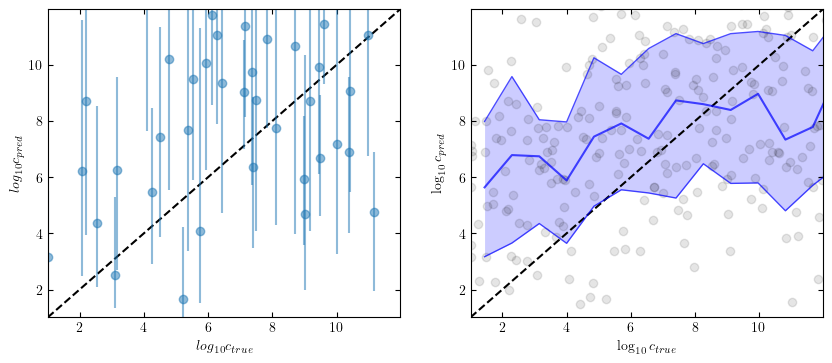

In [1712]:
p = 0.15
mask = np.random.rand(len(true))<p

f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(tnorm.T[1], tnorm.T[1],'k--')
axs[0].errorbar(true[mask,1], cpercs[mask,1], 
                yerr=np.abs(cpercs[mask][:,[0,2]]-cpercs[mask][:,[1]]).T, fmt='o', alpha=0.5)
axs[0].set_xlim(tnorm.T[1])
axs[0].set_ylim(tnorm.T[1])
axs[0].set_xlabel(r'$log_{10}c_{true}$')
axs[0].set_ylabel(r'$log_{10}c_{pred}$')

axs[1].plot(tnorm.T[1],tnorm.T[1],'k--')
axs[1].plot(true[:,1], cpercs[:,1],'ko', alpha=0.1)
binned_plot(true[:,1], cpercs[:,1], 15, color='b', ax=axs[1])
axs[1].set_xlim(tnorm.T[1])
axs[1].set_ylim(tnorm.T[1])
axs[1].set_xlabel(r'$\log_{10}c_{true}$')
axs[1].set_ylabel(r'$\log_{10}c_{pred}$')

f.savefig('ctruepred.jpg', bbox_inches='tight')

## With systematic

### Mass

In [1664]:
# try to uniformly sample from the test set
true = theta_teS[uind]
mbins = np.linspace(true[:,0].min(), true[:,0].max(),30)
ncount = 10

mask = np.zeros(len(true), dtype=bool)
for i in range(len(mbins)-1):
    temp = np.argwhere((true[:,0]>mbins[i]) & (true[:,0]<mbins[i+1])).flatten()
    if len(temp)>0:
        indt = np.random.choice(temp, size=min(ncount,len(temp)), replace=False)
        mask[indt]=True
        
# calc percentiles
inds = np.argwhere(mask).flatten()
Ntest = len(inds)

mpercs = np.zeros((Ntest, 3))
cpercs = np.zeros((Ntest, 3))
for i, ind in enumerate(tqdm(inds)):
    testN = gals_teSN[uind[ind]:uind[ind+1]]
    mpercs[i], cpercs[i] = get_mc_percentiles(density_estimator_S, testN)

true=theta_teS[uind[inds]].numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:33<00:00,  2.72it/s]


In [1665]:
print('stderror:', np.std(true[:,0]- mpercs[:,1]))
print('prior std:', np.diff(tnorm[:,0])/np.sqrt(12))

stderror: 0.29014723170718315
prior std: [0.35825416]


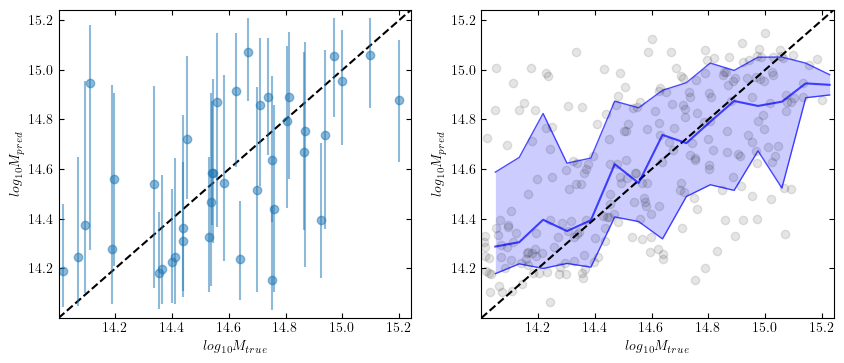

In [1679]:
p = 0.15
mask = np.random.rand(len(true))<p

f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(tnorm.T[0], tnorm.T[0],'k--')
axs[0].errorbar(true[mask,0], mpercs[mask,1], 
                yerr=np.abs(mpercs[mask][:,[0,2]]-mpercs[mask][:,[1]]).T, fmt='o', alpha=0.5)
axs[0].set_xlim(tnorm.T[0])
axs[0].set_ylim(tnorm.T[0])
axs[0].set_xlabel(r'$\log_{10}M_{true}$')
axs[0].set_ylabel(r'$\log_{10}M_{pred}$')

axs[1].plot([14,15.3],[14,15.3],'k--')
axs[1].plot(true[:,0], mpercs[:,1],'ko', alpha=0.1)
binned_plot(true[:,0], mpercs[:,1], 15, color='b', ax=axs[1])
axs[1].set_xlim(tnorm.T[0])
axs[1].set_ylim(tnorm.T[0])
axs[1].set_xlabel(r'$\log_{10}M_{true}$')
axs[1].set_ylabel(r'$\log_{10}M_{pred}$')

f.savefig('mtruepred_S.jpg', bbox_inches='tight')

### Concentration

In [1713]:
# try to uniformly sample from the test set
true = theta_teS[uind]
mbins = np.linspace(true[:,1].min(), true[:,1].max(),30)
ncount = 10

mask = np.zeros(len(true), dtype=bool)
for i in range(len(mbins)-1):
    temp = np.argwhere((true[:,1]>mbins[i]) & (true[:,1]<mbins[i+1])).flatten()
    if len(temp)>0:
        indt = np.random.choice(temp, size=min(ncount,len(temp)), replace=False)
        mask[indt]=True
        
# calc percentiles
inds = np.argwhere(mask).flatten()
Ntest = len(inds)

mpercs = np.zeros((Ntest, 3))
cpercs = np.zeros((Ntest, 3))
for i, ind in enumerate(tqdm(inds)):
    testN = gals_teSN[uind[ind]:uind[ind+1]]
    mpercs[i], cpercs[i] = get_mc_percentiles(density_estimator_S, testN)

true=theta_teS[uind[inds]].numpy()

  0%|                                                                                                                       | 0/249 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/pt/lib/python3.10/site-packages/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 8 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(
  0%|▍                                                                                                              | 1/249 [00:00<00:44,  5.57it/s]/opt/homebrew/anaconda3/envs/pt/lib/python3.10/site-packages/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 7 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.

In [1716]:
print('stderror:', np.std(true[:,1]- cpercs[:,1]))
print('prior std:', np.diff(tnorm[:,1])/np.sqrt(12))

stderror: 3.987884863555999
prior std: [3.1641119]


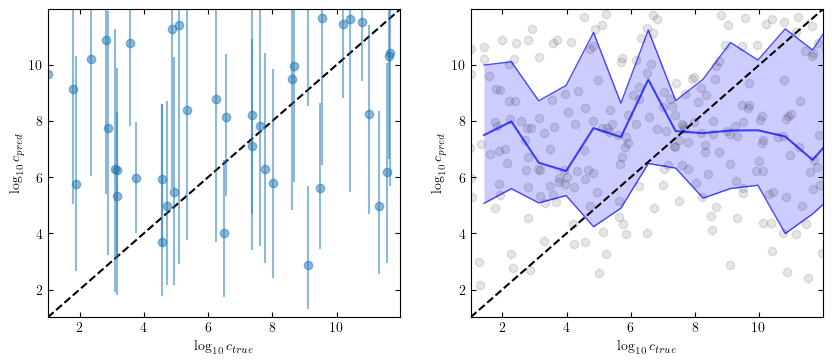

In [1717]:
p = 0.15
mask = np.random.rand(len(true))<p

f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(tnorm.T[1], tnorm.T[1],'k--')
axs[0].errorbar(true[mask,1], cpercs[mask,1], 
                yerr=np.abs(cpercs[mask][:,[0,2]]-cpercs[mask][:,[1]]).T, fmt='o', alpha=0.5)
axs[0].set_xlim(tnorm.T[1])
axs[0].set_ylim(tnorm.T[1])
axs[0].set_xlabel(r'$\log_{10}c_{true}$')
axs[0].set_ylabel(r'$\log_{10}c_{pred}$')

axs[1].plot(tnorm.T[1],tnorm.T[1],'k--')
axs[1].plot(true[:,1], cpercs[:,1],'ko', alpha=0.1)
binned_plot(true[:,1], cpercs[:,1], 15, color='b', ax=axs[1])
axs[1].set_xlim(tnorm.T[1])
axs[1].set_ylim(tnorm.T[1])
axs[1].set_xlabel(r'$\log_{10}c_{true}$')
axs[1].set_ylabel(r'$\log_{10}c_{pred}$')

f.savefig('ctruepred_S.jpg', bbox_inches='tight')

In [1444]:
mbins = np.linspace(true[:,1].min(), true[:,1].max(),30)
ncount = 2

mask = np.zeros(len(true), dtype=bool)
for i in range(len(mbins)-1):
    temp = np.argwhere((true[:,1]>mbins[i]) & (true[:,1]<mbins[i+1])).flatten()
    if len(temp)>0:
        indt = np.random.choice(temp, size=min(ncount,len(temp)), replace=False)
        mask[indt]=True

<ErrorbarContainer object of 3 artists>

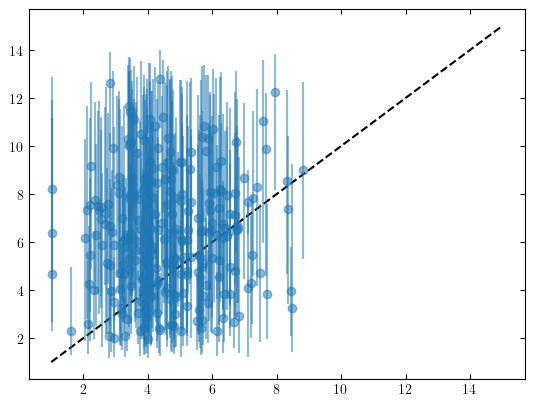

In [1658]:
plt.plot([1,15.],[1,15.],'k--')
plt.errorbar(true[:,1], cpercs[:,1], 
             yerr=np.abs(cpercs[:,[0,2]]-cpercs[:,[1]]).T, fmt='o', alpha=0.5)

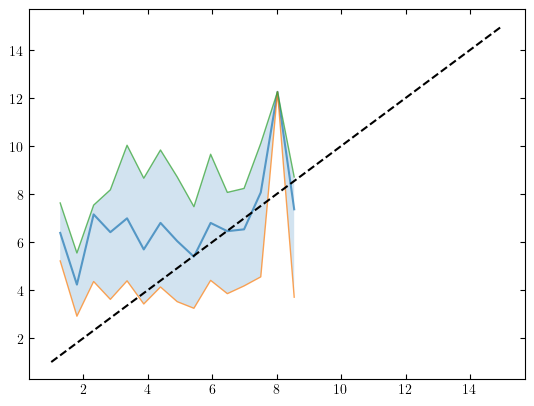

In [1659]:
binned_plot(true[:,1], cpercs[:,1],15)
plt.plot([1,15.],[1,15.],'k--')


In [1060]:
potential_fn, parameter_transform = likelihood_estimator_based_potential(
        density_estimator, prior, testN
    )
logprob0 = potential_fn(torch.Tensor(meshlist.T), track_gradients=False)
logprob0 = logprob0.reshape(mesh.shape[1:]).detach().numpy()

In [1064]:
for i in range(10):
    potential_fn, parameter_transform = likelihood_estimator_based_potential(
        density_estimator, prior, testN[i]
    )
    if i==0:
        logprob = potential_fn(torch.Tensor(meshlist.T), track_gradients=False)
        logprob = logprob.reshape(mesh.shape[1:]).detach().numpy()
    else:
        temp = potential_fn(torch.Tensor(meshlist.T), track_gradients=False)
        logprob += temp.reshape(mesh.shape[1:]).detach().numpy()